# Linear Programming in Optimal Transport

Suppose that the probability measures are discretized over
the set $\mathcal{X} = \{ x_i \in \R \mid i \in I \subset \N, \; \#I = n \}$
and $\mathcal{Y} = \{ y_j \in \R \mid j \in J \subset \N, \; \#J = m \}$
$$
\mu(x) = \sum_i a_i \delta_{x_i} (x)
\quad \text{and} \quad
\nu(y) = \sum_j b_j \delta_{y_j} (y),
$$
where the coefficients $a_i \geq 0 \; \forall i$ and $b_j \geq 0 \; \forall j$ are such that
$$
\sum_i a_i = 1
\quad
\sum_j b_j = 1.
$$

Also, with the cost function $c(x, y) : \mathcal{X} \times \mathcal{Y} \to \R$ we
associate the cost matrix $C \in \R^{n \times m}$ such that
$$
C_{ij} = c(x_i, y_j) \;\; x_i \in \mathcal{X}, \; y_j \in \mathcal{Y}
\quad \forall \; i \in I, \; \forall \; j \in J.
$$

The solution of the OT problem that we will formulate below is the joint
probability measure $\pi \in \R^{n \times m}_{+,0}$ that we call a transport plan,
which satisfies the following constraints:
$$
\sum_j \pi_{i,j} = a_i \quad \forall \; i \in I,
\quad \quad
\sum_i \pi_{i,j} = b_j \quad \forall \; j \in J.
$$

## Discrete OT Problem

Then the **discrete OT problem** is the standard linear programming program
$$
\min_{\pi} \sum_i \sum_j C_{ij} \pi_{ij}
$$
subject to
$$
\sum_j \pi_{ij} = a_i \quad \forall \; i \in I,
\quad \quad
\sum_i \pi_{ij} = b_j \quad \forall \; j \in J.
$$

In [1]:
import pulp
import numpy as np
import matplotlib.pyplot as plt

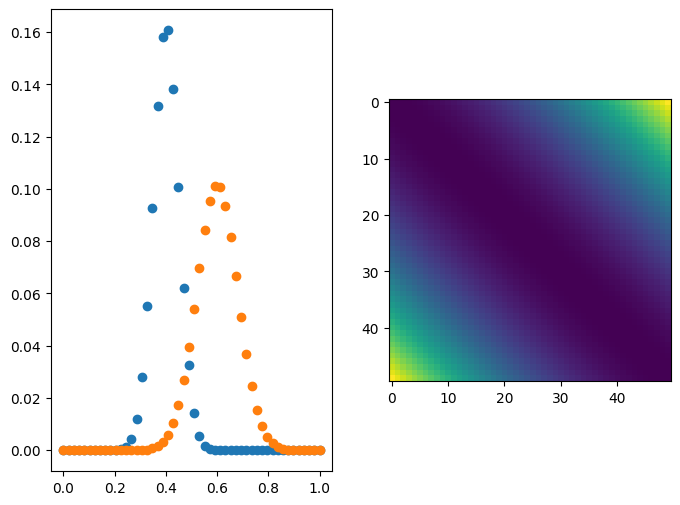

In [ ]:
n = 50
x = np.linspace(0, 1, n)

mu1, sigma1 = 0.4, 0.05
mu2, sigma2 = 0.6, 0.08

a = np.exp(-0.5 * ((x - mu1) / sigma1) ** 2)
b = np.exp(-0.5 * ((x - mu2) / sigma2) ** 2)

# Normalize so that they sum to 1
a /= a.sum()
b /= b.sum()

C = np.power(x[:, None] - x[None, :], 2)

fig, axs = plt.subplots(1, 2, figsize=(8, 6))
axs[0].scatter(x, a)
axs[0].scatter(x, b)
axs[1].imshow(C)

In [4]:
problem = pulp.LpProblem("OT_1D_Problem", pulp.LpMinimize)

pi = []
for i in range(n):
    row_vars = []
    for j in range(n):
        var_name = f"pi_{i}_{j}"
        row_vars.append(pulp.LpVariable(var_name, lowBound=0))
    pi.append(row_vars)

problem += pulp.lpSum(C[i][j] * pi[i][j] for i in range(n) for j in range(n))

# CONSTRAINTS
for i in range(n):
    problem += pulp.lpSum(pi[i][j] for j in range(n)) == a[i], f"a_{i}"

for j in range(n):
    problem += pulp.lpSum(pi[i][j] for i in range(n)) == b[j], f"b_{j}"

In [5]:
problem.solve(pulp.PULP_CBC_CMD(msg=0))

print("Status:", pulp.LpStatus[problem.status])
print("Minimum transport cost = ", pulp.value(problem.objective))

Status: Optimal
Minimum transport cost =  0.04097764633189602


In [6]:
solution = np.zeros((n, n))
for i in range(n):
    for j in range(n):
        solution[i, j] = pulp.value(pi[i][j])

Text(0, 0.5, 'Target index b_j')

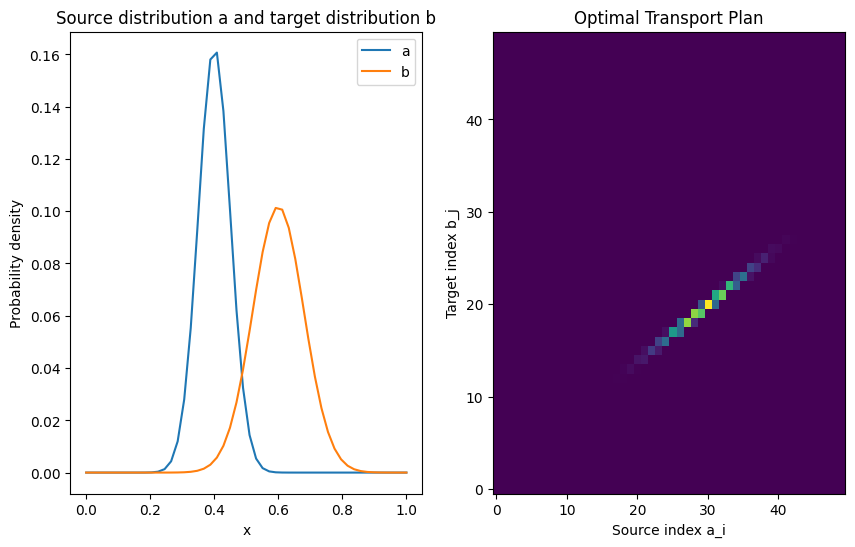

In [9]:
fig, axs = plt.subplots(1, 2, figsize=(10, 6))
axs[0].plot(x, a, label="a")
axs[0].plot(x, b, label="b")
axs[0].set_title("Source distribution a and target distribution b")
axs[0].set_xlabel("x")
axs[0].set_ylabel("Probability density")
axs[0].legend()

axs[1].imshow(solution, origin="lower", aspect="auto")
axs[1].set_title("Optimal Transport Plan")
axs[1].set_xlabel("Source index a_i")
axs[1].set_ylabel("Target index b_j")

## POT Library

In [10]:
import ot

In [11]:
pot_solution = ot.emd(a, b, C)

Text(0, 0.5, 'Target index b_j')

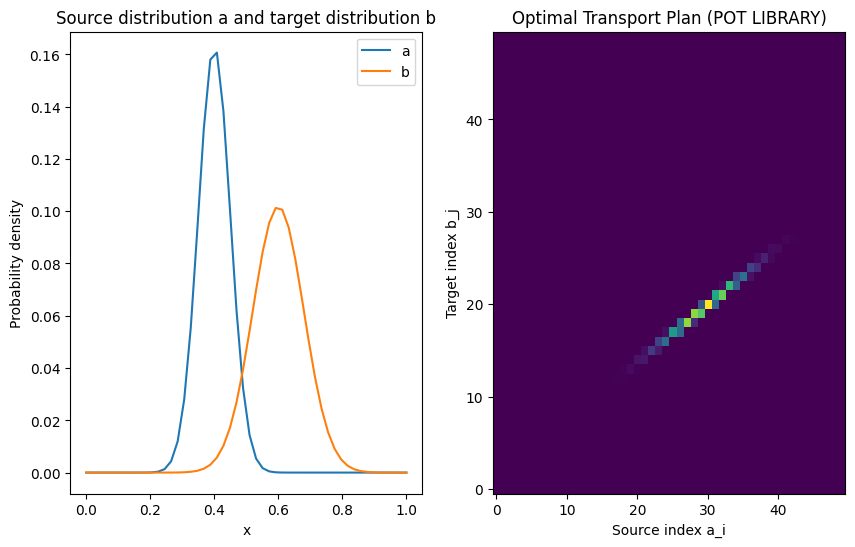

In [12]:
fig, axs = plt.subplots(1, 2, figsize=(10, 6))
axs[0].plot(x, a, label="a")
axs[0].plot(x, b, label="b")
axs[0].set_title("Source distribution a and target distribution b")
axs[0].set_xlabel("x")
axs[0].set_ylabel("Probability density")
axs[0].legend()

axs[1].imshow(pot_solution, origin="lower", aspect="auto")
axs[1].set_title("Optimal Transport Plan (POT LIBRARY)")
axs[1].set_xlabel("Source index a_i")
axs[1].set_ylabel("Target index b_j")